# Stereo Vision - Project Description

In this project you have to solve the stereo vision problem:
Given two images showing a scene from different points of view, the goal is to reconstruct 3D world coordinates for each point in the scene.
You will develop an algorithm, that has as a final output a point cloud, which you will be able to visualize.
The performance will be evaluated based on the dense distance map, i.e. the map of Z coordinates. Additionally the algorithm should output pixel-wise certainties, i.e. a value indicating how certain the prediction of that pixel is.

## One possible strategy

There certainly are more than one good solution to this problem. Here we briefly describe the steps of one possible implementation:

1. Determine all camera calibration parameters. As the parameters might change between scenes - this should be automated.
2. To invert the projection equations (see below) it is necessary to solve the correspondence problem, i.e. the knowledge of which pixel in the first view corresponds to a given pixel in the second view (and vice versa). The special camera setup in this exercise implies very simple *epipolar lines*. This simplifies the correspondece search. During this search a similarity measure of two pixels might come in handy. One such similarity measure was discussed in the lecture - the Normalised Cross Correlation (NCC) of patches.
3. Triangulate the 3D world coordinates for every pixel pair in the left and right image.

## Camera Setup

* The camera setup of this exercise is shown in the figure below
* Througout the exercise it is save to assume $C' = (b, 0, 0)$
* Accordingly, the equations describing a projection of a point (X, Y, Z) onto the cameras are:
\begin{alignat*}{3}
  \text{Left:} \quad x_l &= f k_x \frac{X}{Z} + x_c^{(l)} \qquad & \text{Right:} \quad x_r &= f k_x \frac{X - b}{Z} + x_c^{(r)} \\
                     y_l &= f k_y \frac{Y}{Z} + y_c^{(l)}        &                     y_r &= f k_y \frac{Y}{Z} + y_c^{(r)}
\end{alignat*}
* Some internal parameters will be given to you. Whenever no explicit distinction between left and right camera is made, it is save to assume these parameters are the same for both cameras.

![](https://drive.google.com/uc?export=view&id=1OFkoovPB3sgeOmZKCHxuDnRVysoCFB8b)

## Evaluation

You are given multiple scenes. Your task is to estimate the distance image for every scene, as well as a corresponding certainty score.
We define the distance image as the map of Z coordinates for every pixel in the __left__ camera image. You should write all the distance images as `.npy` files to a `submission.zip` archive. This is the file you should upload to the evaluation server.

The score is based on the error of *inverse distance*. (Otherwise errors will necessarily be larger for objects further away). That is, we define $\tilde z = \frac{1}{z}$. Then the score consits of the following two terms:
1. The un-weighted $R^2$ score
\begin{align*}
  R^2 &= 1 - \frac{\sum_i \left|\tilde z^{(true)}_i - \tilde z^{(pred)}_i\right|^2}{\sum_i \left|\tilde z^{(true)}_i - \mu(\tilde z)\right|^2}
\end{align*}
2. The certainty weighted $R^2$ score
\begin{align*}
  R^2_w &= 1 - \frac{\sum_i w_i \left|\tilde z^{(true)}_i - \tilde z^{(pred)}_i\right|^2}{\sum_i w_i \left|\tilde z^{(true)}_i - \mu(\tilde z)\right|^2}
\end{align*}
3. The final score is the the mean of these two terms
\begin{align*}
  R^2_{final} = \frac{1}{2} \left(R^2 + R^2_w\right)
\end{align*}

Notes:
* In the above expression $\mu(\tilde z) = \frac{1}{N} \sum_i \tilde z^{(true)}_i$ is the target mean.
* The $R^2$ score ranges from $(-\infty, +1]$ (Higher score is better)
* An algorithm predicting a constant distance image, where the constant is exactly the ground truths average has $R^2$ score of zero.
* If you do not want to implement a certainty score - return a constant value of $w_i = 1$ - In that case $R^2 = R^2_w = R^2_{final}$

# Stereo Vision - Implementation

## Task 0.0 - Import packages
TODO: Set the path to your exercise on Google Drive (i.e. set ex_path)

In [6]:
# Import some useful libraries
%matplotlib inline

import os
import sys
import time
import h5py
import yaml
import shutil
from pathlib import Path
from zipfile import ZipFile

import numpy as np
import pandas as pd

from IPython.display import HTML
!pip install plotly
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

# from google.colab import drive

In [7]:
# First mount your drive
# drive_path = Path('/content/drive')
# drive.mount(str(drive_path))

###############   TODO  ###############
# Set path to the exercise folder, e.g. MyDrive/iacv/ex3
iacv_path = '.'
# ex_path = drive_path / iacv_path
ex_path = iacv_path

# Possibly append to PATH
if ex_path not in sys.path:
    sys.path.append(str(ex_path))

In [8]:
# Now we can import from the drive folder
from helper_funcs import create_dir, load_data, test_triangulation, test_ncc, plot_correlation, plot_point_cloud

## Task 0.1 - Load Data
Nothing to do here - just reading and understanding.

In this exercise, there are two scenes: `classroom` and `suzanne`.
For development you can choose to load one of them. You can choose to load them as colour or gray-scale images. The latter might make some implementations easier.

The function `load_data` will return
 * `img_l`: The left camera image
 * `img_r`: The right camera image
 * `calib_dict`: A dictionary with camera intrinsics. Units here are either `[px]` pr `[mm]`
 * `calib_points`: A pandas dataframe that can be used for calibration

In [10]:
# Choose one of {'gray', 'colour'} to load either gray-scale or colour images
CMODE = 'colour'

# Choose one of {'classroom', 'suzanne'} to load different scenes
SCENE = 'classroom'

img_l, img_r, calib_dict, calib_points = load_data(
    data_path=ex_path + '/' + 'data', scene=SCENE, mode=CMODE
)

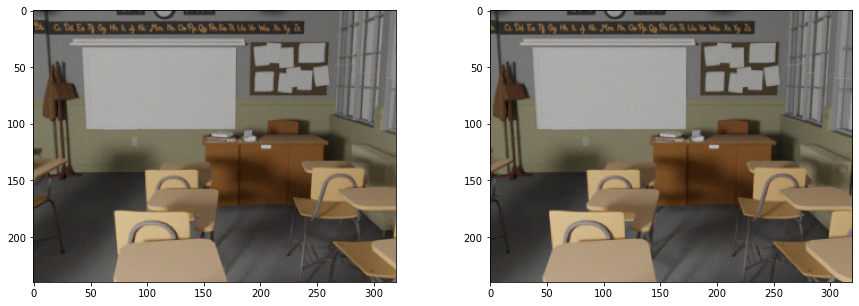

In [11]:
fig, axs = plt.subplots(1, 2, figsize=(15,5))
axs[0].imshow(img_l)
axs[1].imshow(img_r)
plt.show()

One row of the dataframe `calib_points` corresponds to a physical point of the 3d scene. The dataframe has the following columns:
 * `xl [px]` and `yl [px]` ... (x, y) pixel coordinates of the point projected onto the left image. Units are number of pixel.
 * `xr [px]` and `yr [px]` ... (x, y) pixel coordinates of the point projected onto the right image. Units are number of pixel.
 * `X [m]` and `Y [m]` and `Z [m]` ... (X, Y, Z) 3D coordinates of the point wrt the global coordinate system (see figure). Units are meters.

In [12]:
# Some correspondences and world coords are provided to estiamte missing calibration parameters
calib_points

,xl [px],yl [px],xr [px],yr [px],X [m],Y [m],Z [m]
0,72,177,53,177,-0.463158,0.300000,1.842105
1,178,33,172,32,0.300000,-1.450000,5.833333
2,90,115,84,115,-1.166667,-0.083333,5.833333
3,208,121,200,121,0.600000,0.012500,4.375000
4,265,204,252,205,0.807692,0.646154,2.692308
5,217,46,212,46,1.140000,-1.480000,7.000000
6,21,47,15,46,-2.316667,-1.216667,5.833333


In [13]:
# Here are the provided camera parameters
# Note: Units here are either [px] or [mm]!
for k, v in calib_dict.items():
    print(f"{k}: {v}")

height: 240.0
width: 320.0
aperture_h: 24.0
aperture_w: 32.0
xl_c: 160.0
xr_c: 160.0
y_c: 120.0


## Task 1 - Calibration Parameteres

Unforunately some of the parameters, required for our task are missing. You will have to come up with a strategy to compute or estimate the following parameters:
* $k_x$ and $k_y$ (internal parameters): These can be computed easily from the provided data. They stay the same for all scenes.
* Focal lenght $f$ (internal paramter): Might change from scene to scene.
* Base line $b$ (external paramter): Might change from scene to scene. See introductory figure for definition

You're task is to
* Fill the formula for $k_x$ and $k_y$
* Implement the function `def estimate_f_b(calib_dict, calib_points)`

In [14]:
def compute_kx_ky(calib_dict):
    """ Compute kx and ky (in units of [px/mm]). They are the same for both cameras. """
    
    ###############   TODO  ###############
    raise NotImplementedError("ToDo ...")
    
    return kx, ky

In [15]:
kx, ky = compute_kx_ky(calib_dict)

calib_dict['kx'] = kx       # [px/mm] - Shared for both cams
calib_dict['ky'] = ky       # [px/mm] - Shared for both cams

NotImplementedError: ToDo ...

In [16]:
def estimate_f_b(calib_dict, calib_points):
    """
    Estimate focal lenght f and baseline b from the provided calibration points.
    
    Args:
        calib_dict (dict)           ... Incomplete calibaration dictionary
        calib_points (pd.DataFrame) ... Calibration points provided with data. (Units are given in [m])
        
    Returns:
        f   ... Focal lenght [mm]
        b   ... Baseline [mm]
    """
    
    ###############   TODO  ###############
    raise NotImplementedError("ToDo ...")
    
    return f, b

In [17]:
# Fil missing parameters
f, b = estimate_f_b(calib_dict, calib_points, n_points=2)

calib_dict['f'] = f
calib_dict['b'] = b

TypeError: estimate_f_b() got an unexpected keyword argument 'n_points'

## Task 2 - Triangulation

Triangulation is the task of recovering the 3D world coordinates of a *physical point*, given it’s
coordinates in images from two views. Triangulation requires

1. Fully calibrated cameras, i.e. the internal and external camera parameters must be known.
   This was treated in task 1.
2. A solved correspondence problem, i.e. the knowledge of which pixel in the first view corresponds to a given pixel in the second view (and vice versa). We will treat correspondence search in Task 3.

Implement the function `def triangulate(x left, x right, y, calib_dict)` to perform triangulation. See the functions `doc-string` for a description of the inputs and outputs.

In [18]:
def triangulate(x_left, x_right, y, calib_dict):
    """
    Triangulate (determine 3D world coordinates) a set of points given their projected coordinates in two images.
    These equations are according to the simple setup, where C' = (b, 0, 0)

    Args:
        x_left  (np.array of shape (num_points,))   ... Projected x-coordinates of the 3D-points in the left image
        x_right (np.array of shape (num_points,))   ... Projected x-coordinates of the 3D-points in the right image
        y       (np.array of shape (num_points,))   ... Projected y-coordinates of the 3D-points (same for both images)
        calib_dict (dict)                           ... Dict containing camera parameters
    
    Returns:
        points (np.array of shape (num_points, 3)   ... Triangulated 3D coordinates of the input points
    """
    ###############   TODO  ###############
    raise NotImplementedError("ToDo ...")

### Test triangulation

The following will throw an error, if there is a mistake in the first two tasks.

In [19]:
err = test_triangulation(calib_dict, calib_points, triangulation_fn=triangulate)

assert np.isclose(0.0, err, atol=1e-4), \
    f"Test failed with an error of {err:1.4e} :( " \
    "Either f or b are wrong or your triangulation function is wrong (or both)"

NotImplementedError: ToDo ...

## Task 3 - Correspondence Search via Normalized Cross-Correlation

### Description

Triangulation requires coordinates of a “physical” point in the images obtained from both the left and
the right cameras. Thus, for each point (pixel) in the left image, we want to find the corresponding
point in the right image. Given our special camera setup, we know that corresponding points in the
two images must have the same y coordinate. I.e. in this setup, epipolar lines correspond to rows in both images. This simplifies finding point correspondences.

Hence, we can process each horizontal line of the image (ie, each scan line) separately. In order to identify
corresponding points we need a measure of similarity. In this exercise, we will use the normalised cross-correlation measure. The normalised cross-correlation of two points $p_R$ and $p_L$ (in the two views), is
defined with via a pixel neighborhood $\Delta$ (e.g. a square), as

\begin{align*}
  NCC(p_L,p_R) &= \frac{1} {|\Delta| \sigma_L \sigma_R }
  \sum_{p_i\in\Delta} \left[I(p_L+p_i)-\mu_L\right] \cdot \left[I(p_R+p_i)-\mu_R\right] \\
  \mu_R &= \frac{1}{|\Delta|}\sum_{p_i\in\Delta} I(p_R + p_i) \\
  \sigma_R^2 &= \frac{1}{|\Delta|}\sum_{p_i\in\Delta} \left[I(p_R + p_i) - \mu_R\right]^2
\end{align*}

### A note on implementation

* A naive implementation of the above equation might look as follows:
  Iterate (with a for loop) over every pixel in the first image.
  Then iterate (nested for loop) over every possibly corresponding pixel in the second image
  and compute NCC between the patches.
* We highly recommend not to use nested for loops over the image!
* Instead it is possible to have a fast (but more memory-hungry) implementation with numpy operations.
  This approach might be conceptually more challenging, compared to the naive implementation,
  so there is a small hint in the function `compute_ncc` below:
  The main idea is to create a data structure, that allows to efficiently compute the NCC. For this it helps to vectorize the patches.
* You might choose to first implement a slow version with for loops. This can help you understand the more efficient implementation better. But this is optional.
* With an efficient implementation - computing NCC of a full image should take less than 15 seconds (in CoLab)!

Other notes:
* The formula above is for gray scale images. Can you come up with an extension to colour images?

### Demonstration of Speed-up by using NumPy
Run the two approaches given below to compute the mean over the last dimension of a 3-dimensional NumPy array. Observe the difference in computation times.

In [20]:
# Initialize a random numpy array
a = np.random.rand(1000, 1000, 5)

# Approach 1: Naive for loop
t0 = time.time()
a_mean_naive = np.zeros((1000, 1000))
for i in range(a.shape[0]):
    for j in range(a.shape[1]):
        a_mean_naive[i, j] = a[i, j, :].mean()
            
t1 = time.time()
print('Computation took {:.3f} seconds using for loops'.format(t1 - t0))

# Approach 2: Numpy operations
t0 = time.time()
a_mean_numpy = a.mean(axis=2)
t1 = time.time()
print('Computation took {:.3f} seconds using numpy operation'.format(t1 - t0))

Computation took 6.709 seconds using for loops
Computation took 0.031 seconds using numpy operation


### Implementation

In [21]:
def compute_ncc(img_l, img_r, p):
    """
    Calculate normalized cross-correlation (NCC) between patches at the same row in two images.
    
    The regions near the boundary of the image, where the patches go out of image, are ignored.
    That is, for an input image, "p" number of rows and columns will be ignored on each side.

    For input images of size (H, W, C), the output will be an array of size (H - 2*p, W - 2*p, W - 2*p)

    Args:
        img_l (np.array of shape (H, W, C)) ... Left image
        img_r (np.array of shape (H, W, C)) ... Right image
        p (int):                            ... Defines square neighborhood. Patch-size is (2*p+1, 2*p+1).
                              
    Returns:
        corr    ... (np.array of shape (H - 2*p, W - 2*p, W - 2*p))
                    The value output[r, c_l, c_r] denotes the NCC between the patch centered at (r + p, c_l + p) 
                    in the left image and the patch centered at  (r + p, c_r + p) at the right image.
    """

    # Add dummy channel dimension
    if img_l.ndim == 2:
        img_l = img_l[:, :, None]
        img_r = img_r[:, :, None]
    
    assert img_l.ndim == 3, f"Expected 3 dimensional input. Got {img_l.shape}"
    assert img_l.shape == img_r.shape, "Shape mismatch."
    
    H, W, C = img_l.shape
    corr = np.zeros((H - 2*p, W - 2*p, W - 2*p))

    # Hint:
    # Construct a tensor of patches, where patches_left[y, x, :] contains the patch in the left image
    # centered at (x, y) in a vectorized form. This allows you to compute the mean/variance for each patch over
    # the full image using standard numpy operations. The real speed-up however will come from the use of NumPys
    # np.matmul(). You should use this to efficiently compute the many "dot-products", that you see in the NCC equation.
    
    patches_l = np.zeros((H, W, C, (2*p + 1)**2))
    patches_r = np.zeros((H, W, C, (2*p + 1)**2))

    # Construct patches_l and patches_r - by iterating over patch instead of image
    # The numpy function np.roll could be useful here
    for y in range(-p, p+1):
        for x in range(-p, p+1):

            ###############   TODO  ###############
            raise NotImplementedError("ToDo ...")

    # To compute the correlation of vectorized patches - np.matmul() might be useful

### Test NCC (Dummy data)

The following gives you an idea, whether or not the `comupute_ncc` function is implemented correctly.

Expected Result: `[[[1.0, -0.5], [-0.5, 1.0]]]`

In [22]:
test_ncc(compute_ncc)

NotImplementedError: ToDo ...

### Test NCC (Full image)

Compute NCC on a full image. Here is a qualitative reference image, what NCC image for column `100` should look like:

![](https://drive.google.com/uc?export=view&id=128H2k0S1LC6mbYkRA-dPtl-j-i6Rv7Vz)

In [23]:
# Plot the computed NCC for a particular column in the left image
t0 = time.time()
corr = compute_ncc(img_l, img_r, 10)
t1 = time.time()
print("NCC for full image took {:.2f} seconds,".format(t1 - t0))

column_index = 100
plot_correlation(img_l, img_r, corr, column_index, mode=CMODE)

NotImplementedError: ToDo ...

## Task 4 - Stereo Reconstruction

In [24]:
def define_points_3d(img_l, img_r, p, calib_dict):
    """
    Compute point correspondences for two images and perform 3D reconstruction.
    NCC values less than ncc_thrsh are not considered "certain".

    Args:
        img_l (np.array of shape (H, W, C)) ... Left image
        img_r (np.array of shape (H, W, C)) ... Right image
        p (int)                             ... Defines square neighborhood for NCC.
                                                Patch-size will be (2*p+1, 2*p+1).
        calib_dict (dict)                   ... Dict containing camera parameters
    
    Returns:
        points3d (np.array of shape (H, W, 4)
            Array containing the re-constructed 3D world coordinates for each pixel in the left image.
            Boundary points - which are not well defined for NCC might be padded with 0s.
            4th dimension holds the certainties.
    """

    # Add dummy channel dimension
    if img_l.ndim == 2:
        img_l = img_l[:, :, None]
        img_r = img_r[:, :, None]
    
    assert img_l.ndim == 3, f"Expected 3 dimensional input. Got {img_l.shape}"
    assert img_l.shape == img_r.shape, "Shape mismatch."
    
    H, W, C = img_l.shape

    ###############   TODO  ###############
    raise NotImplementedError("ToDo ...")

### Visualization of 3D point cloud

Finally you are able to visualise the 3D point cloud :) Again, here is qualitative reference image, of what this could look like.
(Of coures depending on some hyper-parameters of your algorithm)

![](https://drive.google.com/uc?export=view&id=1Jx1pIDFmMDkV62_-J1GtAS8UQaVID8iu)

In [25]:
t0 = time.time()
points3d = define_points_3d(img_l, img_r, 15, calib_dict, ncc_thrsh=0.75)
t1 = time.time()
print("Computation took {:.2f} seconds,".format(t1 - t0))

TypeError: define_points_3d() got an unexpected keyword argument 'ncc_thrsh'

In [26]:
fig = plot_point_cloud(img_l, img_r, points3d)
HTML(fig.to_html())

NameError: name 'points3d' is not defined

## Submission

The following cell will run your code to reconstruct 3D coordinates for all the different scenes. It will then store the distance images (i.e. the Z coordinates for every pixel in the left image) and store them in a `submission` directory. TYou can then download this directory as `submission.zip` from your Google Drive and upload to the evaluation server.

* Depending on your implementation - you might need to change some things here.
* Make sure to set your __hyper-parameters__ here! E.g. when you implemented a more advanced reconstruction method.

In [ ]:
def compute_submission(sub_dir, hyper_params):
    """ Loop over scenes and compute distance images """
    
    for scene in ['classroom', 'suzanne']:
    
        CMODE = hyper_params[scene]['CMODE']
        p = hyper_params[scene]['p']
    
        # Load data
        img_l, img_r, calib_dict, calib_points = load_data(
            data_path=ex_path / 'data', scene=scene, mode=CMODE
        )
    
        # Fill calibration dictionary
        calib_dict['kx'], calib_dict['ky'] = compute_kx_ky(calib_dict)
        calib_dict['f'], calib_dict['b'] = estimate_f_b(calib_dict, calib_points, n_points=2)
    
        # Reconstruct distance image
        points3d = define_points_3d(img_l, img_r, p, calib_dict)
        prediction = points3d[:, :, 2:]
    
        # Check that size is correct
        assert prediction.shape[:2] == img_l.shape[:2], \
            "Distance image has different shape than original input! Maybe you forgot padding?"
    
        # Write distance image to disc
        np.save(sub_dir / (scene + '.npy'), prediction)

    # Also submit this notebook
    shutil.copyfile(ex_path / '3_stereo_handout.ipynb', sub_dir / '3_stereo_handout.ipynb')

In [ ]:
# Set your hyper-parameters
hyper_params = {
    'suzanne': {
        'CMODE': 'colour',
        'p': 10
    },
    'classroom': {
        'CMODE': 'colour',
        'p': 10
    }
}

# Set up submission directory
sub_dir = ex_path / 'submission'
create_dir(sub_dir)

In [ ]:
compute_submission(sub_dir, hyper_params)